<a href="https://colab.research.google.com/github/ismael-almazan/Programaci-n-para-anal-tica-descriptiva-y-predictiva/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance del Proyecto

Detección de fraude financiero con analítica descriptiva y predictiva


**Etapas: Métricas de Calidad de los Datos, Análisis Descriptivo y Preprocesamiento**

Nombre: Ismael Almazan Luna

Matrícula: 263177

Fecha: 29/09/2025

## 1) Introducción
Descripción breve del problema que se pretende abordar.
*  Identificar patrones que permitan detectar transacciones financieras fraudulentas en tiempo real o lo más pronto posible.
*  Predecir si una transacción es legítima o fraudulenta con base en sus características (monto, frecuencia, tipo de operación, etc.).


Objetivo general del proyecto y objetivos específicos.
*  El objetivo del análisis es identificar patrones y factores clave que distinguen a las transacciones legítimas de las fraudulentas, para desarrollar modelos predictivos que permitan reducir las pérdidas financieras y aumentar la seguridad de los usuarios y las instituciones.

Contexto del dataset en relación con el problema planteado.
*  Es un dataset con datos estructurado.
*  Se trata de un dataset sintetico generadocon el simulador PaySim,creado para suplir la escasa disponibilidad de datos reales de transacciones financieras debido a su caracter altamente sensible.


## 2) Descripción del dataset
- Fuente de los datos:  Fuente: Synthetic Financial Datasets For Fraud Detection. Kaggle.
- Número de registros y variables.
  +  Numero de filas(registros): 6,362,620transacciones
  +  Numero de columnas(atributos): 11
***************************************************************************
     step  Número de paso en la simulación (representa el tiempo).

     type: Tipo de transacción (por ejemplo, CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER).

     amount: Monto de la transacción.

     nameOrig: ID del cliente que inicia la transacción.

     oldbalanceOrg: Saldo anterior del cliente que inicia la transacción.

     newbalanceOrig: Nuevo saldo del cliente que inicia la transacción después de la operación.

     nameDest: ID del cliente que recibe la transacción.

     oldbalanceDest: Saldo anterior del cliente receptor.

     newbalanceDest: Nuevo saldo del cliente receptor después de la operación.

     isFraud: Indicador de fraude (1 si la transacción es fraudulenta, 0 si es legítima).

     isFlaggedFraud: Indicador de fraude detectado por el sistema (1 si el sistema marcó la transacción como fraudulenta, 0 si no).
***************************************************************************
- Variables principales de interés.
Se utilizaran todas las varibles, sin embargo ya para la aplicacion de algun modelo de prediccion (Modelos de Clasificación Supervisada, No supervisada, Redes Neuronales, etc.) debido que transacciones que se detectan como fraude se cancelan, por lo que para la detección de fraude no se deben utilizar las columnas (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ).

Limitaciones del dataset.

El dataset "Synthetic Financial Datasets For Fraud Detection" de Kaggle es un conjunto de datos sintético diseñado para la detección de fraude. Aunque es muy útil para desarrollar y probar modelos, tiene varias limitaciones que debes considerar:
*  Datos no reales: Al ser generados por un simulador, pueden no capturar la complejidad y los patrones del mundo real, lo que afecta la generalización del modelo.

*  Distribución artificial: La proporción de fraudes en el dataset sintético puede no reflejar la rareza del fraude en la realidad (típicamente <1%), lo que afecta el entrenamiento en casos de clases desbalanceadas.

*  Características limitadas: Puede que no incluya todas las variables importantes o las relaciones entre ellas pueden ser más simples que en datos reales.

*  Evolución del fraude no capturada: Los patrones de fraude en la vida real cambian, y el modelo entrenado con datos sintéticos podría no adaptarse a nuevas técnicas.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.cm as cm
import scipy.stats as stats

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

#Cargar de Dataset que esta en mi Drive
df_original = pd.read_csv("/content/drive/MyDrive/ClassFiles/DatosK.csv")

print("Dimensiones:", df_original.shape)
display(df_original.head(10))

#Contar numero de observaciones donde isFraud=1 y donde es Iafraud=0
print("Numero de fraudes", len(df_original[df_original['isFraud'] == 1]))
print("Numero de No fraudes",len(df_original[df_original['isFraud'] == 0]))

##Contar porcentajes de observaciones de fraude y no fraude
print("Porcentaje de fraudes", len(df_original[df_original['isFraud'] == 1])/len(df_original)*100)
print("Porcentaje de No fraudes",len(df_original[df_original['isFraud'] == 0])/len(df_original)*100)



Dimensiones: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


Numero de fraudes 8213
Numero de No fraudes 6354407
Porcentaje de fraudes 0.12908204481801522
Porcentaje de No fraudes 99.87091795518198


**Reducion de la dimension del dataset**

Dado que el datset es muy grande (+6M) se reducirla la clase mayor (no fruade) ya que es aprox. el 99.87% y fraude es solo el 0.1290%

Para tratar el desbalance de clase, la clae mayoritaria de No frude se reducira a un radio de 1:20 mantininedo las propociones para cada variable categorica (step y tipo de transaccion)


In [3]:


df_fraud = df_original[df_original["isFraud"] == 1]
df_nonfraud = df_original[df_original["isFraud"] == 0]

RATIO = 20
TARGET_NONFRAUD = len(df_fraud) * RATIO

print("Fraudes:", len(df_fraud))
print("No fraudes:", len(df_nonfraud))
print("Objetivo de no fraudes:", TARGET_NONFRAUD)

# Proporcion de cada grupo (step, type)
group_counts = df_nonfraud.groupby(["step", "type"]).size()
group_proportions = group_counts / group_counts.sum()

group_samples = (group_proportions * TARGET_NONFRAUD).astype(int)

group_samples = group_samples.reset_index()
group_samples.columns = ["step", "type", "n"]

# Merge  con df_original
df_nonfraud = df_nonfraud.merge(group_samples, on=["step", "type"], how="left")

# Sample vectorizado
df_nonfraud_reduced = (
    df_nonfraud.groupby(["step", "type"])
               .apply(lambda g: g.sample(n=min(len(g), int(g["n"].iloc[0])),
                                         random_state=42))
               .reset_index(drop=True)
)

# Unimos fraudes + no fraudes reducidos
df = pd.concat([df_fraud, df_nonfraud_reduced], ignore_index=True)

# Mezclar
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Tamaño final:")
print(df["isFraud"].value_counts())


Fraudes: 8213
No fraudes: 6354407
Objetivo de no fraudes: 164260


/tmp/ipython-input-3153081177.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), int(g["n"].iloc[0])),


Tamaño final:
isFraud
0    163250
1      8213
Name: count, dtype: int64


## 3) Preguntas de análisis descriptivo

- ¿Cuál es la distribución de fraude vs. no fraude en el dataset?
- ¿Cómo se distribuyen las transacciones fraudulentas y no fraudulentas en el tiempo (horas, días?
- ¿Qué diferencias existen en los montos de las transacciones entre las transacciones fraudulentas y las legítimas?
- ¿Cómo se relacionan las categorías de transacciones (tipo de transacción, origen, destino) con la variable de fraude?
- ¿Cómo se distribuyen las transacciones por tipo de operación y cuál es la tasa de fraude asociada a cada categoría?

## 4) Métricas de calidad de los datos

*  El dataset no presenta valores faltantes, por lo que no requiere imputación de datos ni modificaciones adicionales.

*  Asimismo, no contiene datos duplicados, por lo que no es necesario eliminarlos. Sin embargo, en un escenario en el que existieran duplicados, no sería recomendable eliminarlos, ya que podrían aportar información relevante o patrones que faciliten la detección de fraude.

In [4]:
# Valores faltantes
print("Valores faltantes:")
display(df.isnull().sum())

# Duplicados
print("Duplicados:")
display(df.duplicated().sum())

# Tipos de datos
print("Tipos de datos:")
display(df.dtypes)

Valores faltantes:


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Duplicados:


np.int64(0)

Tipos de datos:


,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


## 5) Análisis descriptivo de los datos

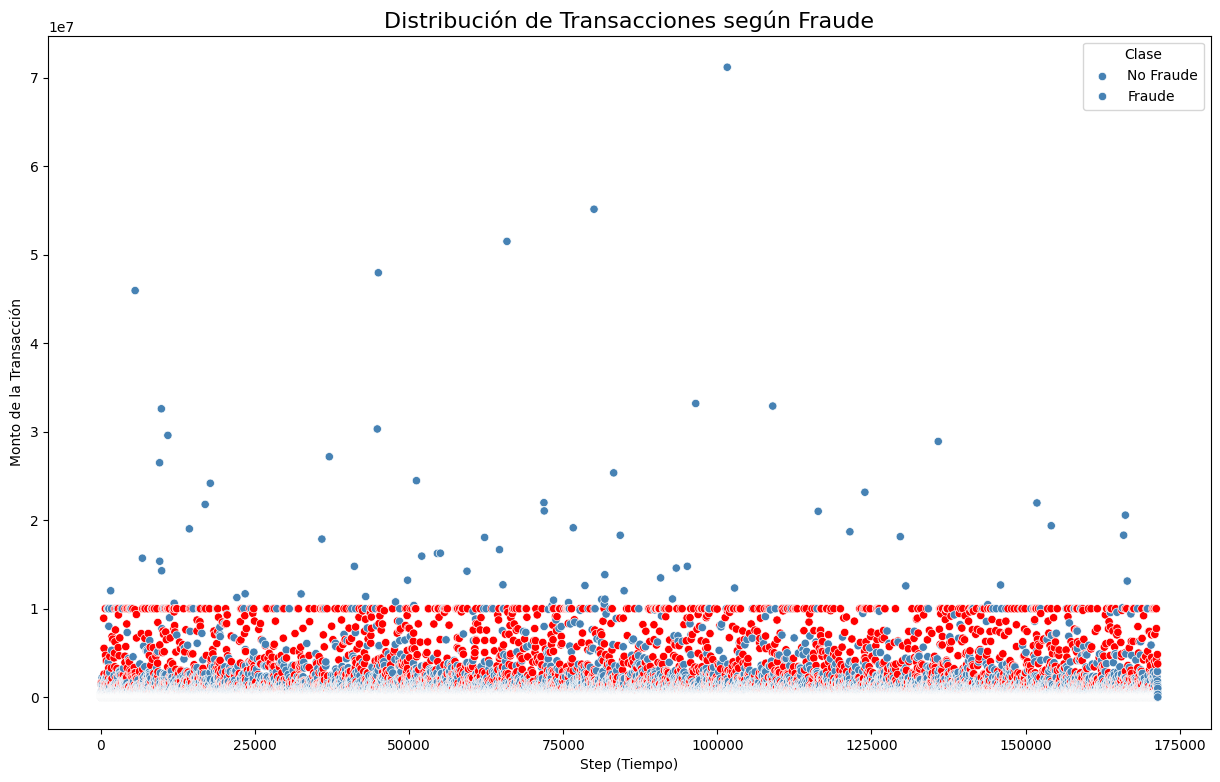

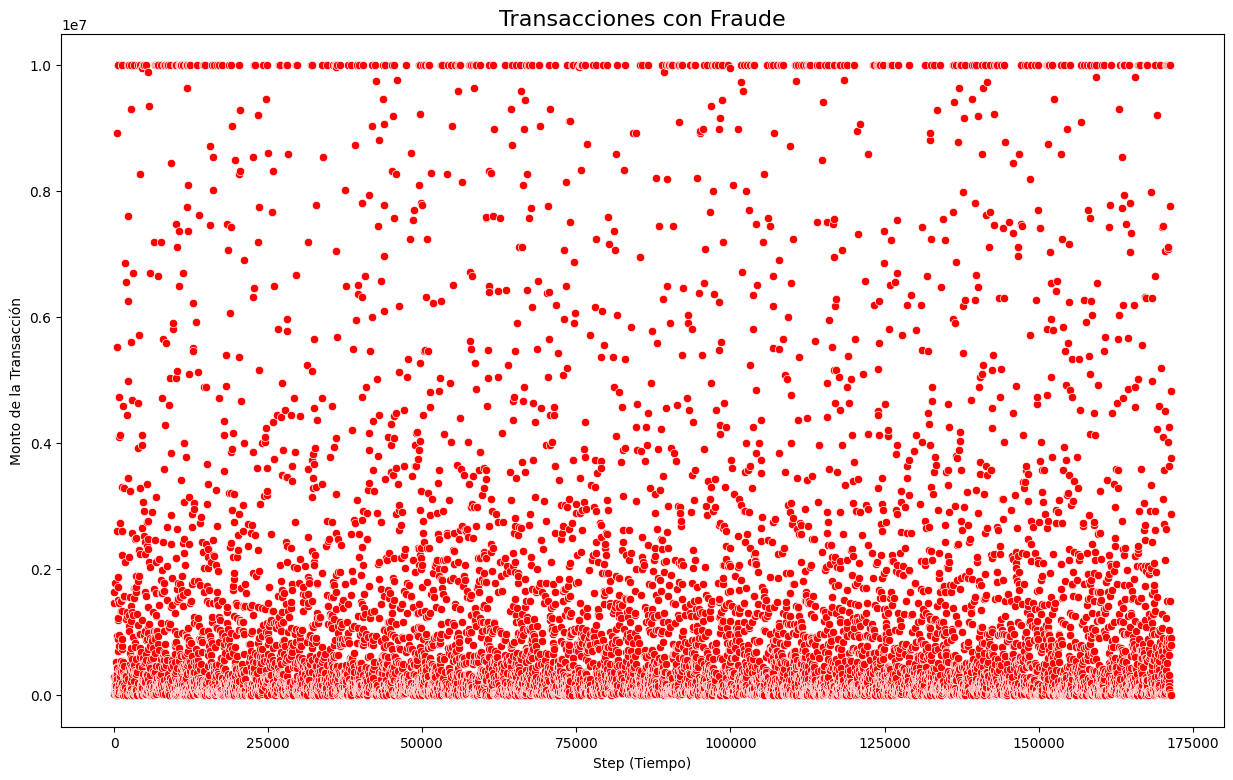

Categorias donde estan los fraudes


,count
type,
CASH_OUT,4116
TRANSFER,4097
CASH_IN,0
DEBIT,0
PAYMENT,0


/tmp/ipython-input-357106955.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['isFraud'] == 1], x='type', order=df[df['isFraud'] == 1]['type'].value_counts().index, palette='Blues')


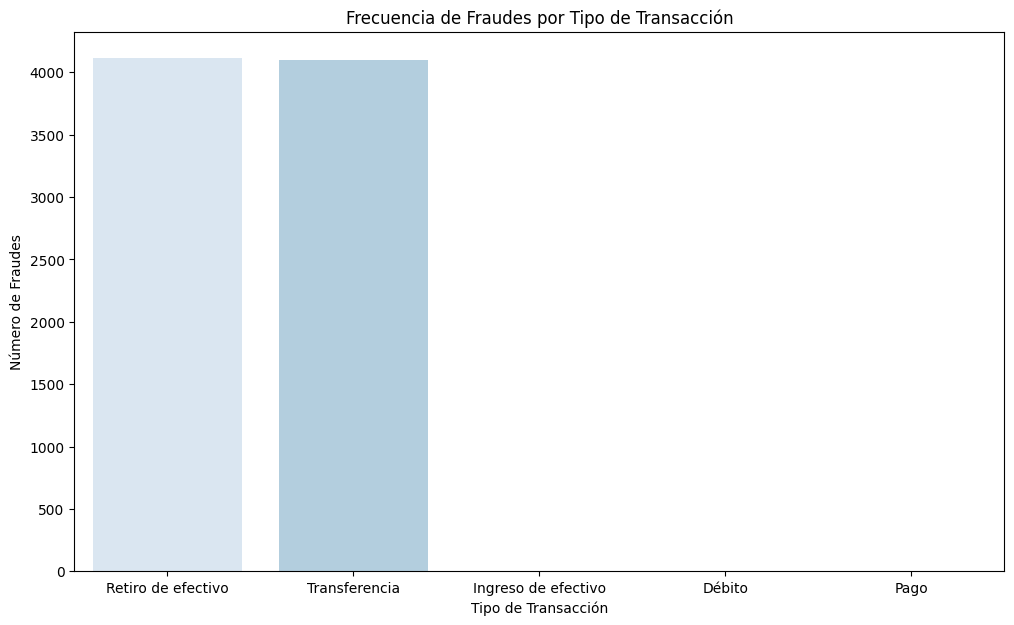

/tmp/ipython-input-357106955.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', palette='Blues')


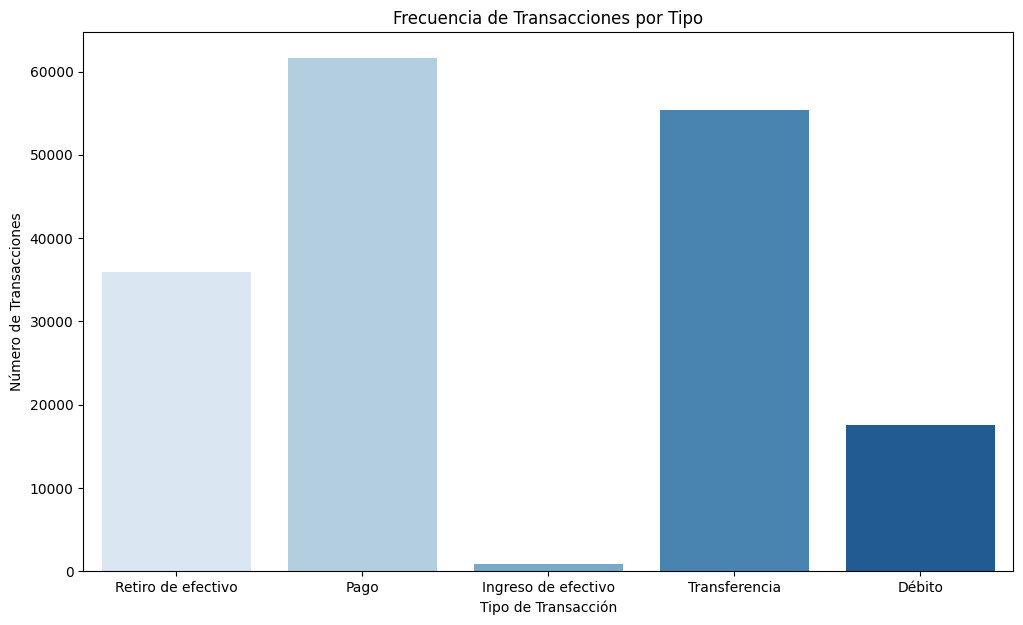

/tmp/ipython-input-357106955.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df[(df["isFraud"] == 1) & (df["type"] == "TRANSFER")], x="amount", bins=12, kde=True, ax=axes[0], palette='Blues')
/tmp/ipython-input-357106955.py:59: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df[(df["isFraud"] == 1) & (df["type"] == "CASH_OUT")], x="amount", bins=12, kde=True, ax=axes[1], palette='Blues')


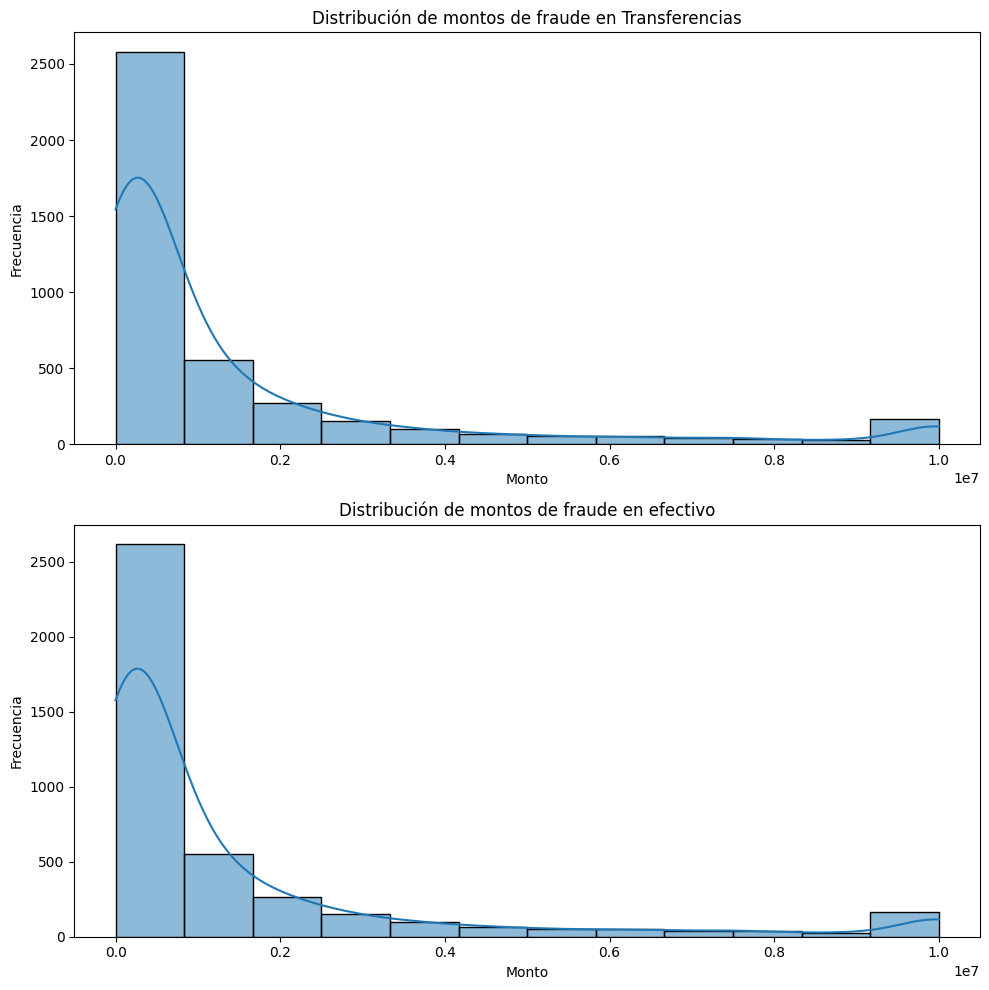

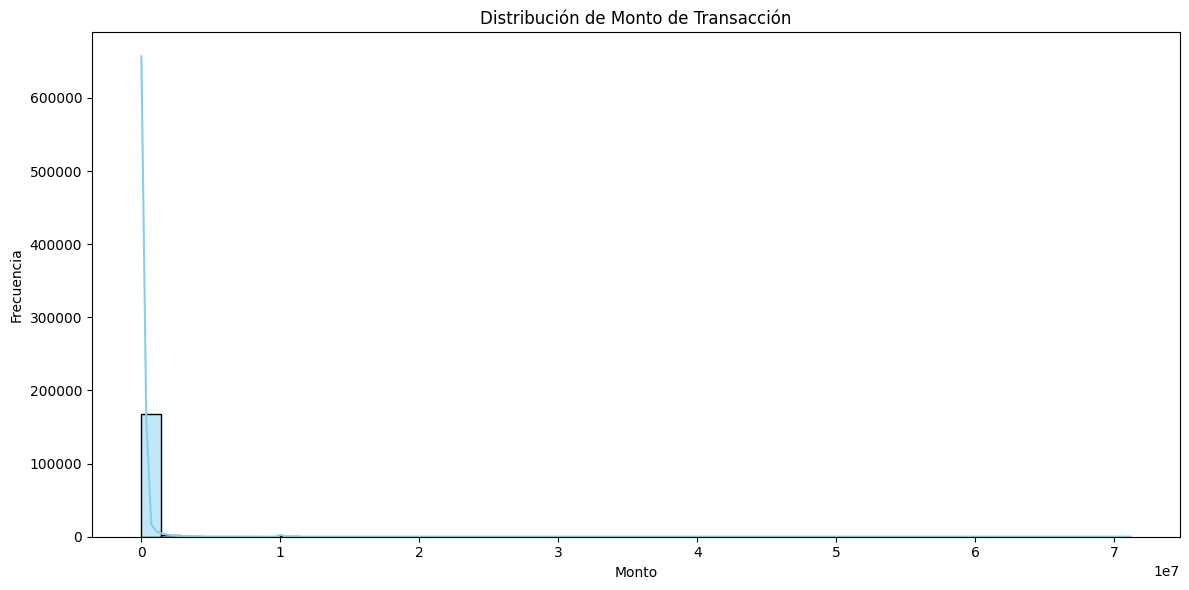

Valor máximo de amount: 71172480.42
Valor mínimo de amount: 0.0


,Frecuencia Absoluta,Frecuencia Relativa %
amount,,
"(-71172.48, 7117248.042]",170770,99.60
"(7117248.042, 14234496.084]",650,0.38
"(14234496.084, 21351744.126]",23,0.01
"(21351744.126, 28468992.168]",9,0.01
"(28468992.168, 35586240.21]",6,0.00
"(35586240.21, 42703488.252]",0,0.00
"(42703488.252, 49820736.294]",2,0.00
"(49820736.294, 56937984.336]",2,0.00
"(56937984.336, 64055232.378]",0,0.00


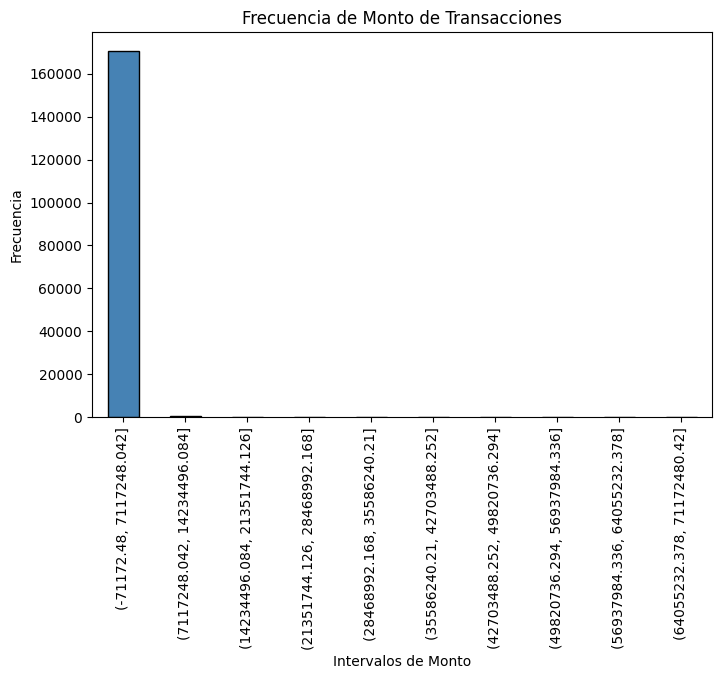

In [12]:
# Estadísticos básicos de datset
df.describe()

#Scatter para visualizar como se distribuyen ls transacciones clasificadas como fraude a travez del tiempo (step)
plt.figure(figsize=(15, 9))
sns.scatterplot(data=df, x=df.index, y='amount', hue='isFraud',palette={0: 'steelblue', 1: 'red'})
plt.legend(title='Clase', labels=['No Fraude', 'Fraude'])
plt.title("Distribución de Transacciones según Fraude", fontsize=16)
plt.xlabel("Step (Tiempo)")
plt.ylabel("Monto de la Transacción")
plt.show()

# Distribucion solo de los fruades en un scatter
plt.figure(figsize=(15, 9))
sns.scatterplot(data=df[df['isFraud'] == 1], x=df.index[df['isFraud'] == 1], y='amount', color='red')
plt.title("Transacciones con Fraude", fontsize=16)
plt.xlabel("Step (Tiempo)")
plt.ylabel("Monto de la Transacción")
plt.show()


#Identificar en que tipo de transacciones estan los fraudes  (Se identidica que los fraudes solo estan en las transacciones de CASH_OUT	y TRANSFER)
print("Categorias donde estan los fraudes")
display(df[df['isFraud'] == 1]['type'].value_counts())

#Traduccion de etiquetas
type_etiquetas = {'CASH_IN': 'Ingreso de efectivo', 'CASH_OUT': 'Retiro de efectivo', 'DEBIT': 'Débito', 'PAYMENT': 'Pago', 'TRANSFER': 'Transferencia'}

#Grafuico de barras
plt.figure(figsize=(12,7))
sns.countplot(data=df[df['isFraud'] == 1], x='type', order=df[df['isFraud'] == 1]['type'].value_counts().index, palette='Blues')
plt.xticks(ticks=range(len(type_etiquetas)), labels=[type_etiquetas[t] for t in df[df['isFraud']==1]['type'].value_counts().index])
plt.title("Frecuencia de Fraudes por Tipo de Transacción")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Número de Fraudes")
plt.show()

#Grafica en un barplot type y su frecuencia
plt.figure(figsize=(12,7))
sns.countplot(data=df, x='type', palette='Blues')
plt.xticks(ticks=range(len(type_etiquetas)), labels=[type_etiquetas[t] for t in df['type'].value_counts().index])
plt.title("Frecuencia de Transacciones por Tipo")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Número de Transacciones")
plt.show()


#Histograma de como se distribiyen los fraudes en cada clase (TRANSFER  Y CASH_OUT)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Histograma TRANSFER
sns.histplot(data=df[(df["isFraud"] == 1) & (df["type"] == "TRANSFER")], x="amount", bins=12, kde=True, ax=axes[0], palette='Blues')
axes[0].set_title("Distribución de montos de fraude en Transferencias")
axes[0].set_xlabel("Monto")
axes[0].set_ylabel("Frecuencia")

# Histograma CASH_OUT
sns.histplot(data=df[(df["isFraud"] == 1) & (df["type"] == "CASH_OUT")], x="amount", bins=12, kde=True, ax=axes[1], palette='Blues')
axes[1].set_title("Distribución de montos de fraude en efectivo")
axes[1].set_xlabel("Monto")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

#Distribucion de montos (amount)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='amount', bins=50, kde=True, color='skyblue')
plt.title('Distribución de Monto de Transacción')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Algunos valores son extremadamente altos y podrían considerarse atípicos. Sin embargo, no es recomendable eliminarlos, ya que proporcionan información valiosa sobre  la ocurrencia de fraudes incluso en transacciones de gran monto.

#Valores max y min de amount
print("Valor máximo de amount:", df['amount'].max())
print("Valor mínimo de amount:", df['amount'].min())

#Generar tabla de frecuencia absoluta y relativa porcentual de amount con 10 clases
tabla_frecuencia = pd.cut(df['amount'], bins=10).value_counts().sort_index()
tabla_frecuencia_relativa = (tabla_frecuencia / tabla_frecuencia.sum() * 100).round(2)
tablaf = pd.DataFrame({'Frecuencia Absoluta': tabla_frecuencia,'Frecuencia Relativa %': tabla_frecuencia_relativa})
display(tablaf)

#Histograma
plt.figure(figsize=(8,5))
tabla_frecuencia.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Frecuencia de Monto de Transacciones")
plt.xlabel("Intervalos de Monto")
plt.ylabel("Frecuencia")
plt.show()



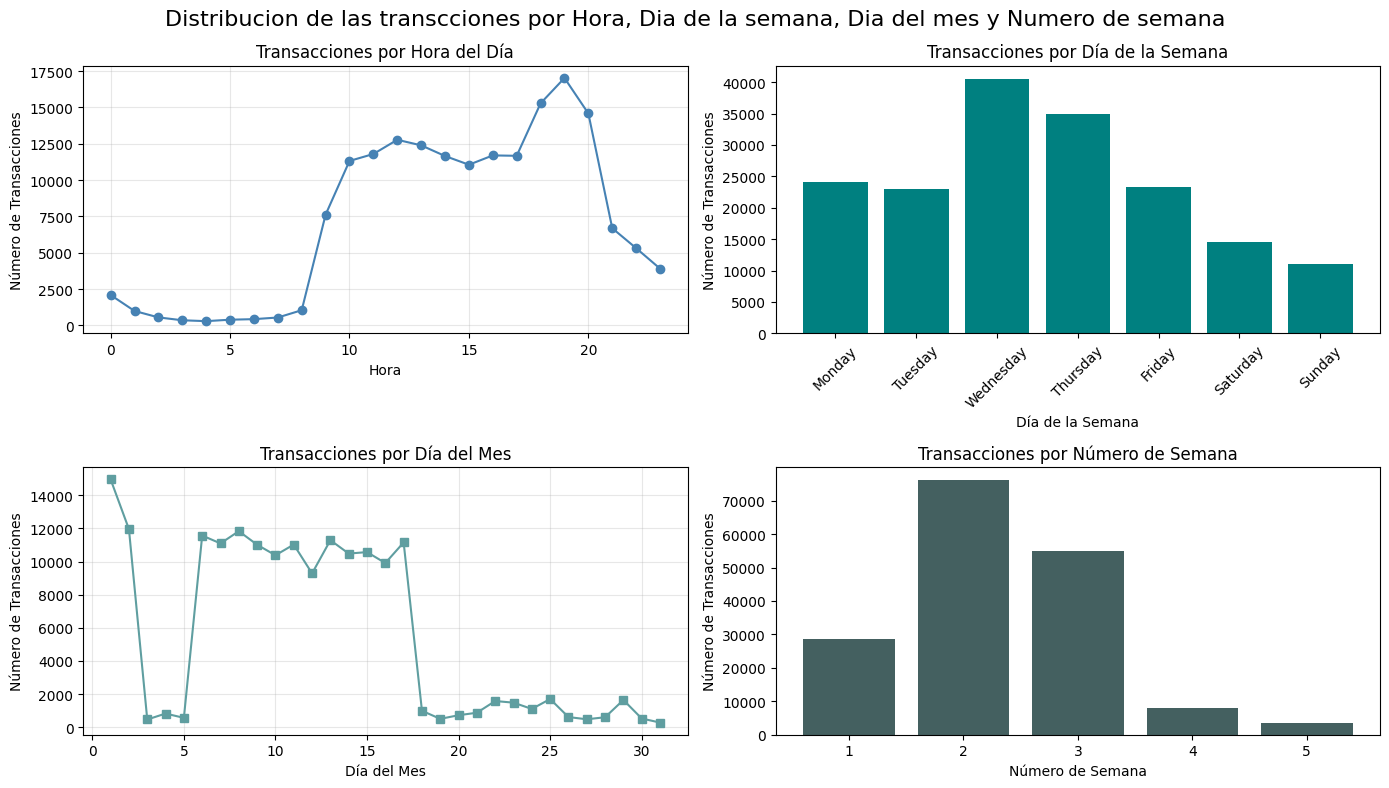

In [6]:

#Cómo se distribuyen las transacciones por Hora, Día de la semana, Día del Mes y semanas

# Extraer componentes temporales para análisis
df['hora'] = df['timestamp'].dt.hour
df['dia_semana'] = df['timestamp'].dt.day_name()
df['dia_mes'] = df['timestamp'].dt.day
df['semana'] = df['timestamp'].dt.isocalendar().week  # Número de semana

# Gráfico
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("Distribucion de las transcciones por Hora, Dia de la semana, Dia del mes y Numero de semana", fontsize=16)

# 1. Por hora del día
trans_por_hora = df.groupby('hora').size()
axes[0,0].plot(trans_por_hora.index, trans_por_hora.values, marker='o', color='steelblue')
axes[0,0].set_title('Transacciones por Hora del Día')
axes[0,0].set_xlabel('Hora')
axes[0,0].set_ylabel('Número de Transacciones')
axes[0,0].grid(True, alpha=0.3)

# 2. Por día de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trans_por_dia = df.groupby('dia_semana').size().reindex(dias_orden)
axes[0,1].bar(trans_por_dia.index, trans_por_dia.values, color='teal')
axes[0,1].set_title('Transacciones por Día de la Semana')
axes[0,1].set_xlabel('Día de la Semana')
axes[0,1].set_ylabel('Número de Transacciones')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Por día del mes
trans_por_dia_mes = df.groupby('dia_mes').size()
axes[1,0].plot(trans_por_dia_mes.index, trans_por_dia_mes.values, marker='s', color='cadetblue')
axes[1,0].set_title('Transacciones por Día del Mes')
axes[1,0].set_xlabel('Día del Mes')
axes[1,0].set_ylabel('Número de Transacciones')
axes[1,0].grid(True, alpha=0.3)

# 4. Por número de semana
trans_por_semana = df.groupby('semana').size()
axes[1,1].bar(trans_por_semana.index, trans_por_semana.values, color='darkslategray', alpha=0.9)
axes[1,1].set_title('Transacciones por Número de Semana')
axes[1,1].set_xlabel('Número de Semana')
axes[1,1].set_ylabel('Número de Transacciones')


plt.tight_layout()
plt.show()


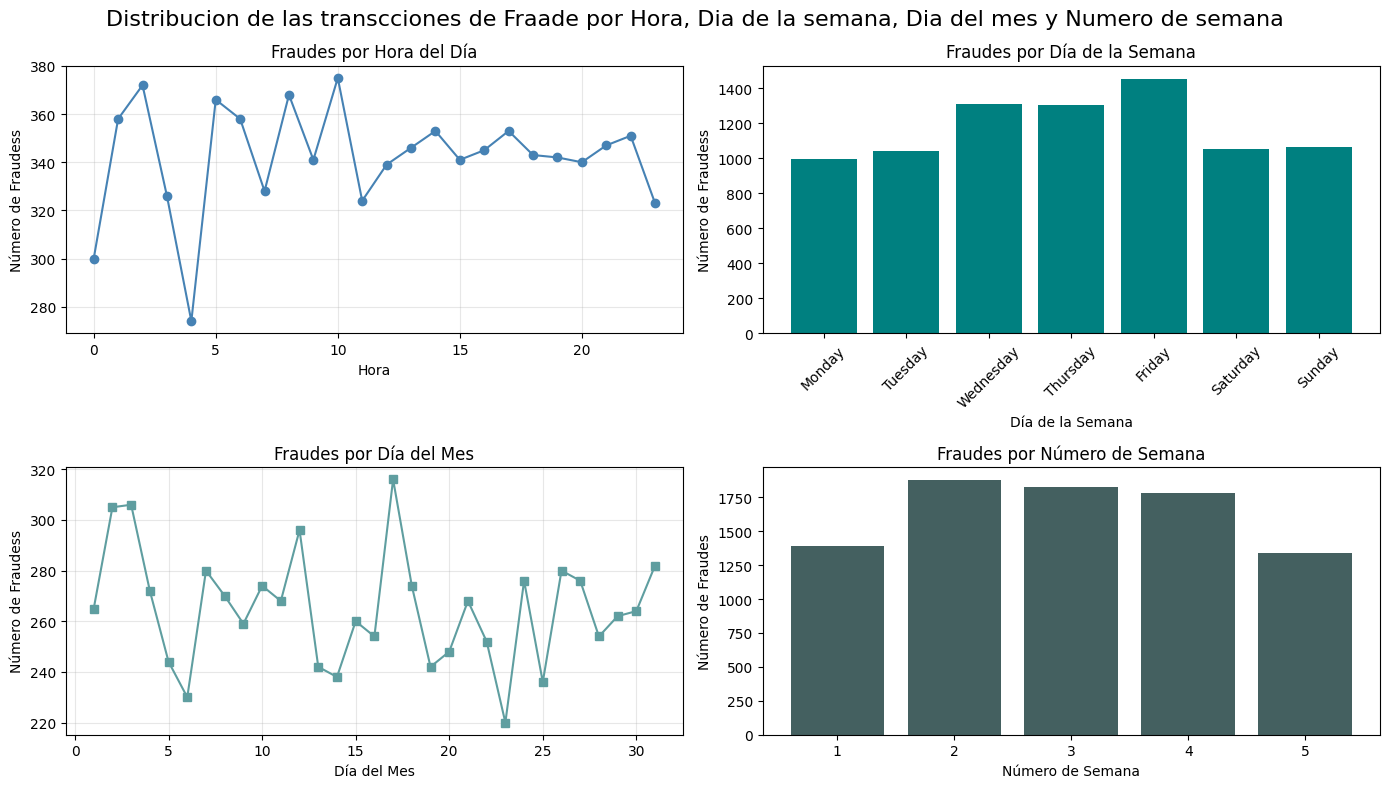

In [7]:
#Como se distribuyen las transacciones calsificadas como Fraude  por Hora, Dia de la semana, Dia del Mes y semanas

# Extraer componentes temporales para análisis
fraudes_df = df[df['isFraud'] == 1].copy()

# Gráfico múltiple de patrones
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("Distribucion de las transcciones de Fraade por Hora, Dia de la semana, Dia del mes y Numero de semana", fontsize=16)


# 1. Por hora del día
fraudes_por_hora = fraudes_df.groupby('hora').size()
axes[0,0].plot(fraudes_por_hora.index, fraudes_por_hora.values, marker='o', color='steelblue')
axes[0,0].set_title('Fraudes por Hora del Día')
axes[0,0].set_xlabel('Hora')
axes[0,0].set_ylabel('Número de Fraudess')
axes[0,0].grid(True, alpha=0.3)

# 2. Por día de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraudes_por_dia = fraudes_df.groupby('dia_semana').size().reindex(dias_orden)
axes[0,1].bar(fraudes_por_dia.index, fraudes_por_dia.values, color='teal')
axes[0,1].set_title('Fraudes por Día de la Semana')
axes[0,1].set_xlabel('Día de la Semana')
axes[0,1].set_ylabel('Número de Fraudess')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Por día del mes
fraudes_por_dia_mes = fraudes_df.groupby('dia_mes').size()
axes[1,0].plot(fraudes_por_dia_mes.index, fraudes_por_dia_mes.values, marker='s', color='cadetblue')
axes[1,0].set_title('Fraudes por Día del Mes')
axes[1,0].set_xlabel('Día del Mes')
axes[1,0].set_ylabel('Número de Fraudess')
axes[1,0].grid(True, alpha=0.3)

# 4. POR NÚMERO DE SEMANA
fraudes_por_semana = fraudes_df.groupby('semana').size()
axes[1,1].bar(fraudes_por_semana.index, fraudes_por_semana.values, color='darkslategray', alpha=0.9)
axes[1,1].set_title('Fraudes por Número de Semana')
axes[1,1].set_xlabel('Número de Semana')
axes[1,1].set_ylabel('Número de Fraudes')


plt.tight_layout()
plt.show()

## 6) Preprocesamiento de los datos

*  Se redujo la cantidad de observaciones, específicamente las clasificadas como no fraude, a 1/5 de su tamaño original. (El procedimiento se encuentra al inicio cuando se caragn los datos)

*  La variable type se convirtió de tipo object a categórica.

*  A partir de la variable step se generó una nueva variable de tipo temporal.

Comparacion de dataset original vs el reducido donde se mantuvo la propocion de las transacciones generadas en cada hora(step)

In [5]:
# Conversión de tipo de dato de type la cual es categoorica
df['type'] = df['type'].astype('category')
valores_unicos = df['type'].cat.categories
print("Categorias", valores_unicos)

#la varible step representa horas y mide el tiempo transcurrido desde el inicio del periodo de simulación:
#1 step = 1 hora
#el dataset simula transacciones a lo largo de 30 días (720 horas)
# Por lo tanto, los valores van desde step 1 hasta step 720
#Para fines practicos se convertira a datos temporales suponinedo que las transacciones inican el primer dia de un mes a final mes para un dia de 30dias (septiembre)
print("Maximo:",df['step'].max())
print("\nMinimo:",df['step'].min())
df['timestamp'] = pd.to_datetime('2025-01-01 00:00:00') + pd.to_timedelta(df['step'], unit='h')
print("\nPrimeras filas con timestamp:")
display(df[['step', 'timestamp']].head())

#Comparar el resumen de estadisticas decriptivas del df origial y el reducido
print("\nResumen de estadisticas descriptivas del dataset original:")
display(df_original.describe())
print("\nResumen de estadisticas descriptivas del dataset reducido:")
display(df.describe())

Categorias Index(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'], dtype='object')
Maximo: 743

Minimo: 1

Primeras filas con timestamp:


,step,timestamp
0,329,2025-01-14 17:00:00
1,201,2025-01-09 09:00:00
2,302,2025-01-13 14:00:00
3,210,2025-01-09 18:00:00
4,160,2025-01-07 16:00:00



Resumen de estadisticas descriptivas del dataset original:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00



Resumen de estadisticas descriptivas del dataset reducido:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,n,timestamp
count,171463.000000,1.714630e+05,1.714630e+05,1.714630e+05,1.714630e+05,1.714630e+05,171463.000000,171463.000000,163250.000000,171463
mean,248.701761,2.409270e+05,8.586453e+05,8.109982e+05,1.065396e+06,1.217898e+06,0.047900,0.000093,226.980655,2025-01-11 08:42:06.338627072
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,2025-01-01 01:00:00
25%,156.000000,1.427409e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,155.000000,2025-01-07 12:00:00
50%,250.000000,8.239155e+04,1.844400e+04,0.000000e+00,1.083832e+05,2.052670e+05,0.000000,0.000000,237.000000,2025-01-11 10:00:00
75%,347.000000,2.228078e+05,1.408520e+05,1.263411e+05,9.014807e+05,1.109552e+06,0.000000,0.000000,307.000000,2025-01-15 11:00:00
max,743.000000,7.117248e+07,5.958504e+07,4.958504e+07,2.405919e+08,2.885448e+08,1.000000,1.000000,512.000000,2025-01-31 23:00:00
std,148.483539,8.524750e+05,2.875787e+06,2.836258e+06,3.250952e+06,3.560864e+06,0.213554,0.009660,113.297059,NaN


## 7) Análisis exploratorio de los datos



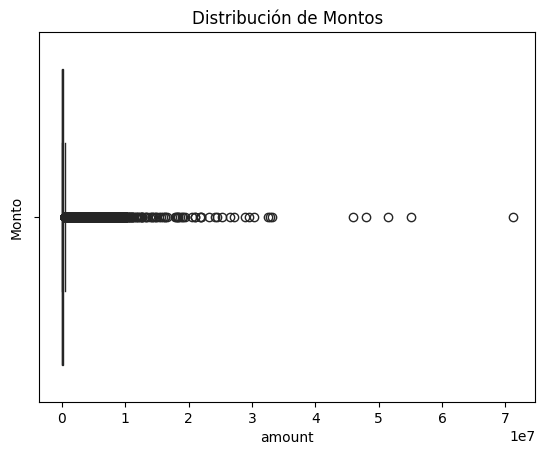

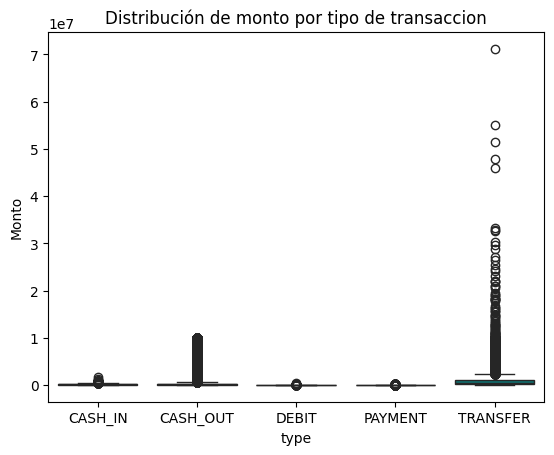

In [8]:
#Boxplot de mpunt
sns.boxplot(x='amount', data=df, color='teal')
plt.title('Distribución de Montos')
plt.ylabel('Monto')
plt.show()

#boxplots por clase de "type"
sns.boxplot(x='type', y='amount', data=df, color='teal')
plt.title('Distribución de monto por tipo de transaccion')
plt.suptitle('')
plt.ylabel('Monto')
plt.show()

**Pruebas de Normalidad**

Tipo de datos de las variables de df
step                       int64
type                    category
amount                   float64
nameOrig                  object
oldbalanceOrg            float64
newbalanceOrig           float64
nameDest                  object
oldbalanceDest           float64
newbalanceDest           float64
isFraud                    int64
isFlaggedFraud             int64
n                        float64
timestamp         datetime64[ns]
hora                       int32
dia_semana                object
dia_mes                    int32
semana                    UInt32
dtype: object


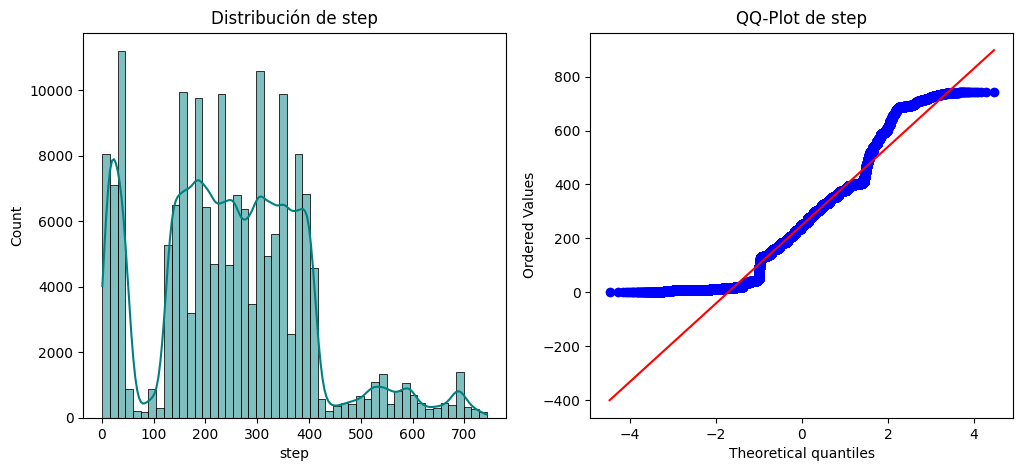


Pruebas de normalidad para la columna: step
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 1173.56517
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


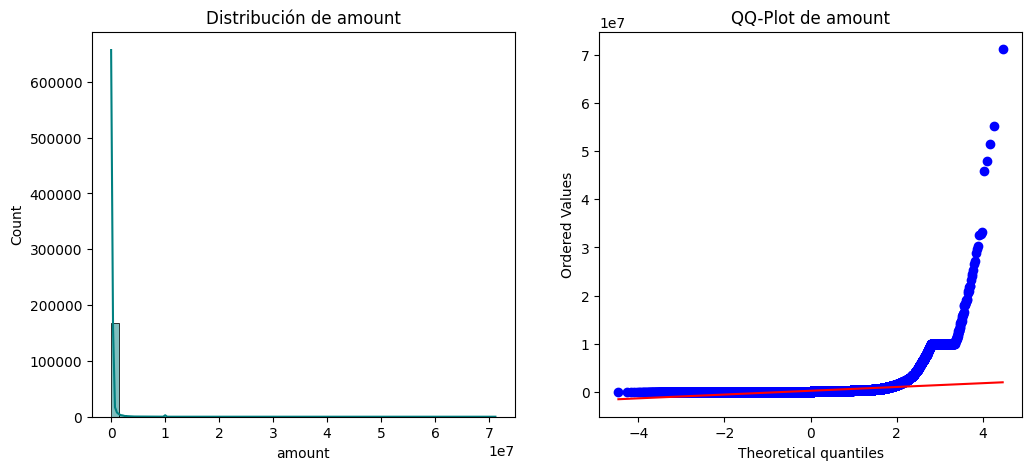


Pruebas de normalidad para la columna: amount
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 39599.80820
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


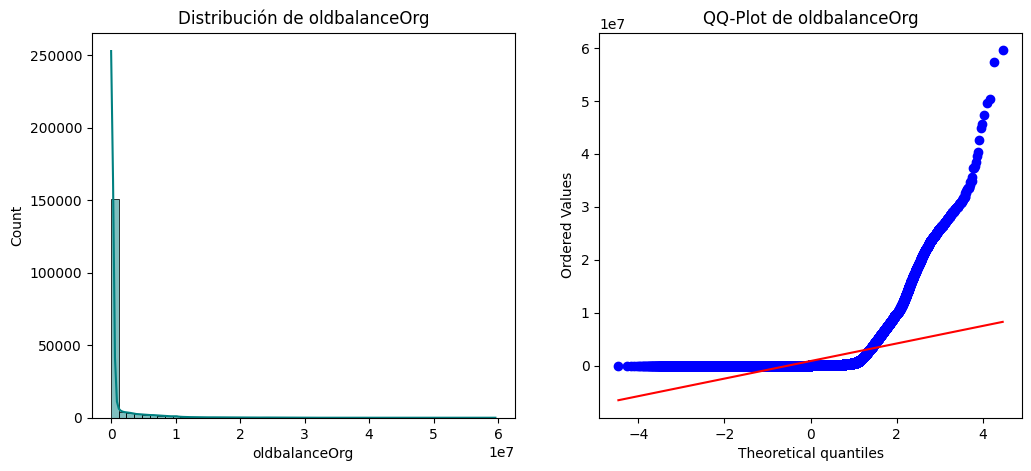


Pruebas de normalidad para la columna: oldbalanceOrg
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 44631.32550
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


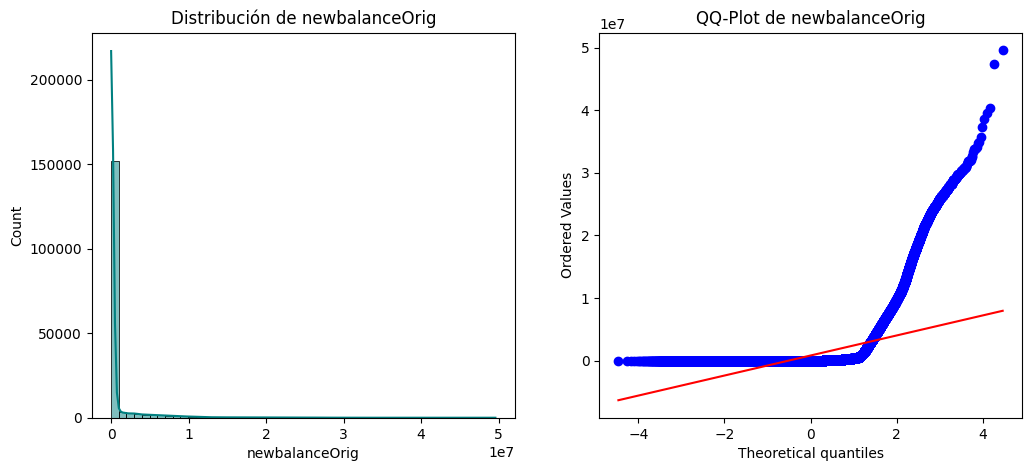


Pruebas de normalidad para la columna: newbalanceOrig
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 46177.26124
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


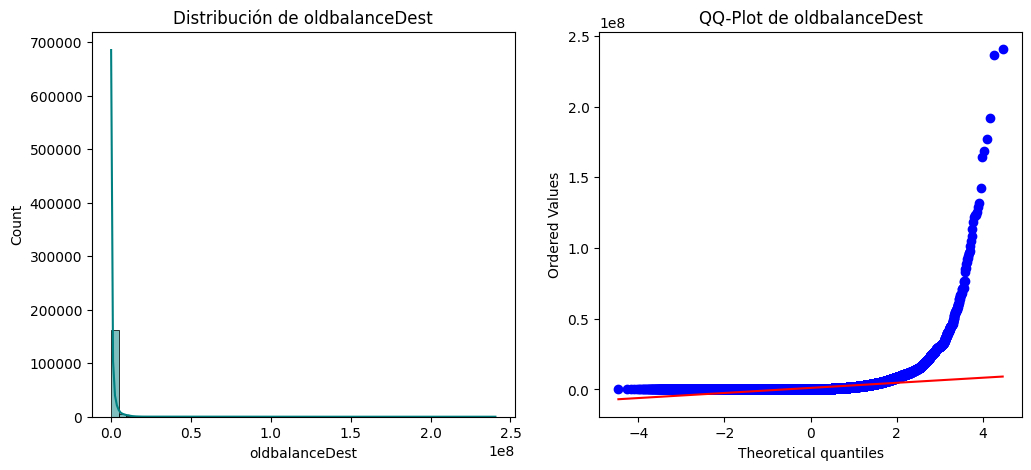


Pruebas de normalidad para la columna: oldbalanceDest
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 33212.45210
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


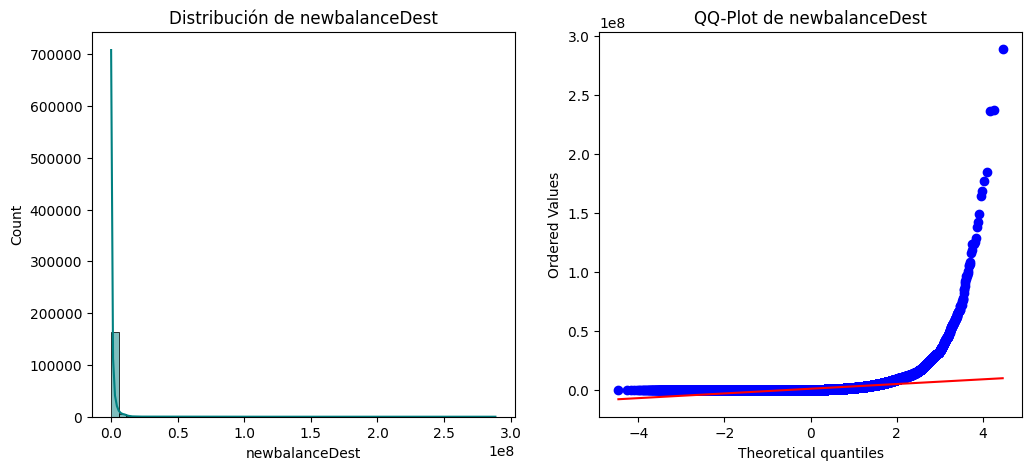


Pruebas de normalidad para la columna: newbalanceDest
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 31784.07017
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


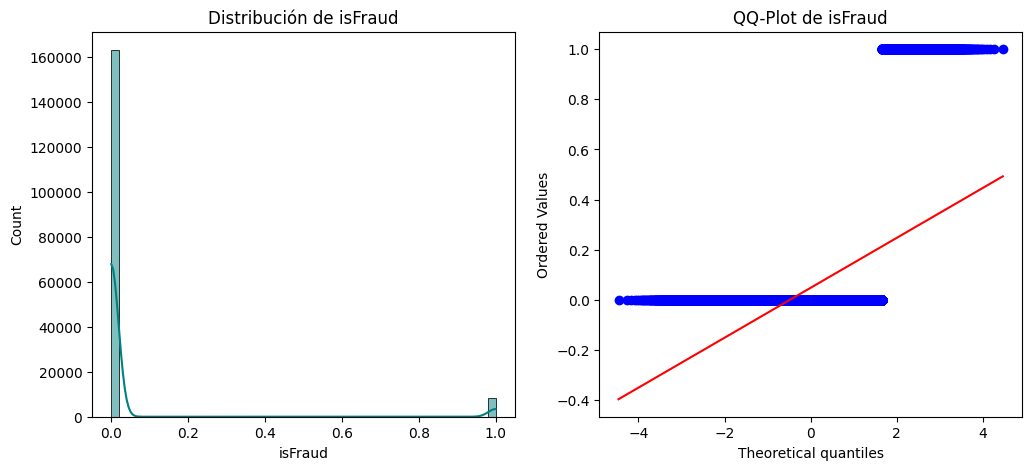


Pruebas de normalidad para la columna: isFraud
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 62146.05300
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


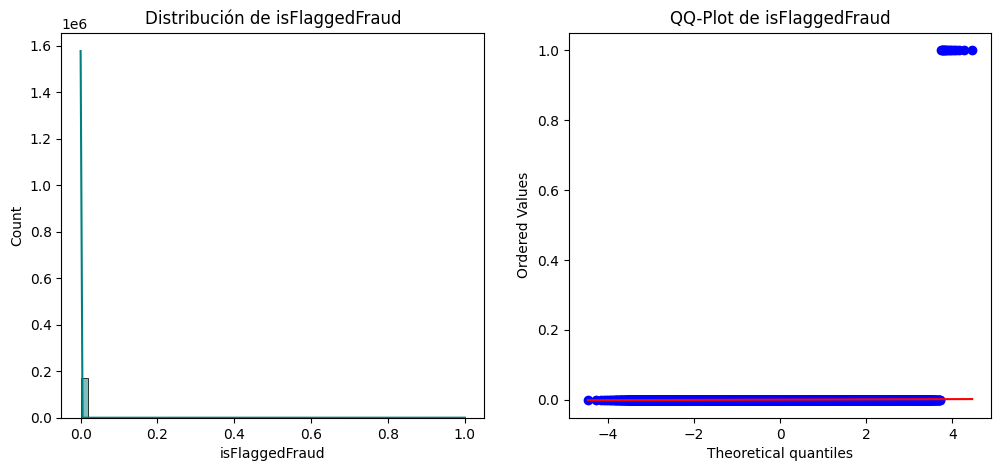


Pruebas de normalidad para la columna: isFlaggedFraud
Shapiro-Wilk Test: p-valor = 1.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 66230.95605
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


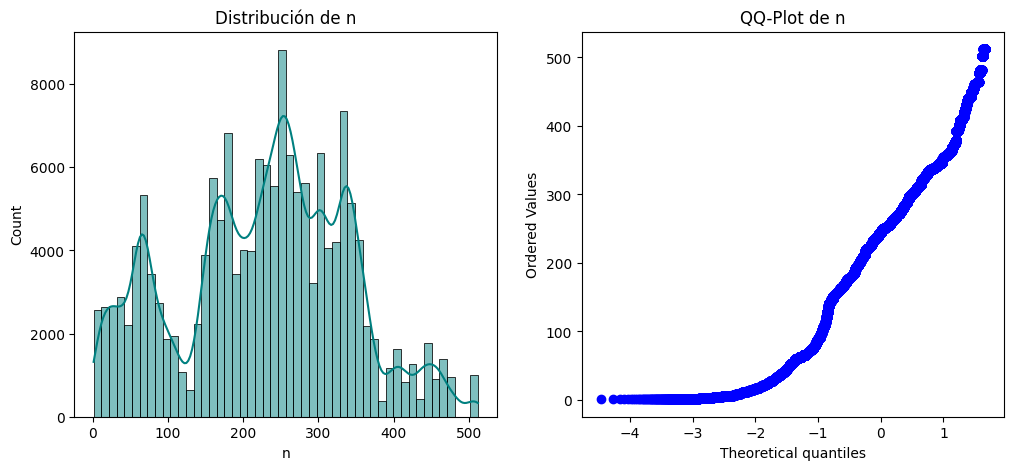


Pruebas de normalidad para la columna: n
Shapiro-Wilk Test: p-valor = nan
Kolmogorov-Smirnov Test: p-valor = nan
Anderson-Darling Test: Estadístico = nan
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = nan


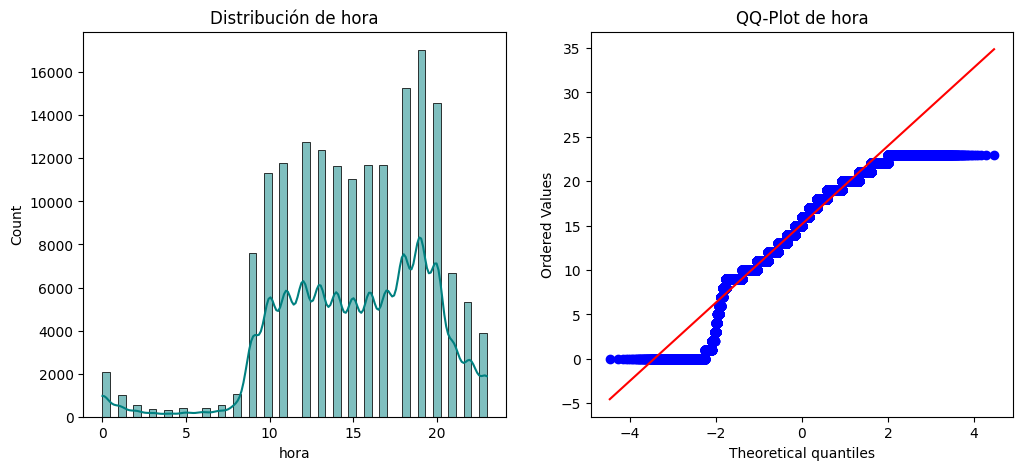


Pruebas de normalidad para la columna: hora
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 1611.90317
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


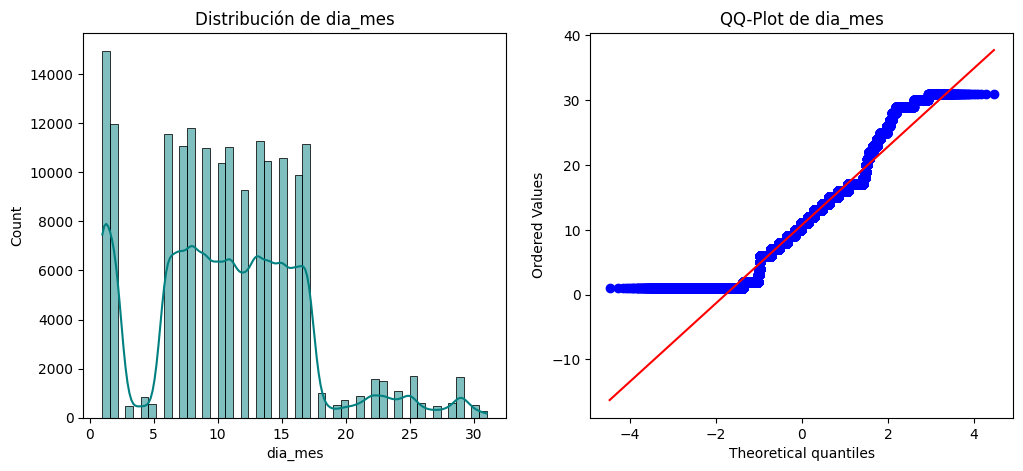


Pruebas de normalidad para la columna: dia_mes
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 1401.87767
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


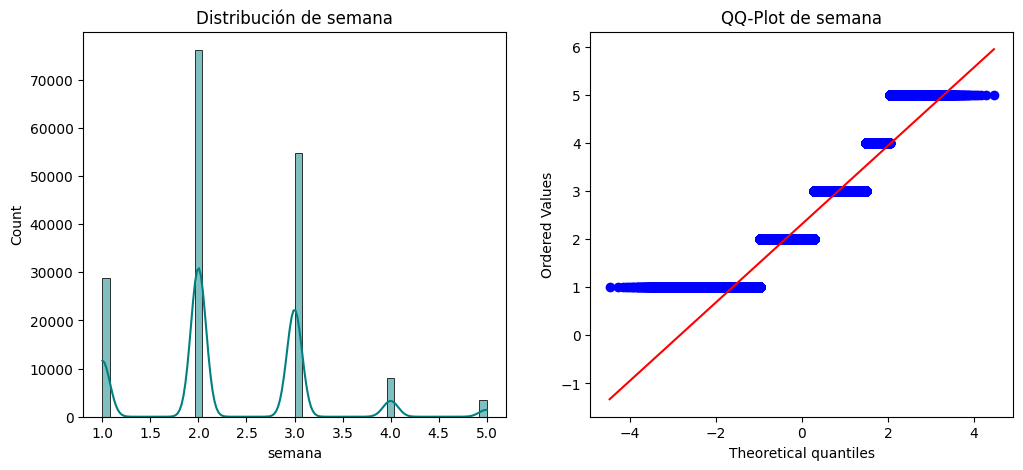


Pruebas de normalidad para la columna: semana
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 9853.63769
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


In [9]:

# Seleccionar solo columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

#Tipo de de datos de las variables de df
print("Tipo de datos de las variables de df")
print(df.dtypes)

# Función para realizar pruebas de normalidad
def normality_tests(data, column_name):
    print(f"\nPruebas de normalidad para la columna: {column_name}")

    # Prueba de Shapiro-Wilk
    shapiro_test = stats.shapiro(data.sample(min(5000, len(data)), random_state=42))  # Muestra de 5000 para evitar problemas de cómputo
    print(f"Shapiro-Wilk Test: p-valor = {shapiro_test.pvalue:.5f}")

    # Prueba de Kolmogorov-Smirnov
    ks_test = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"Kolmogorov-Smirnov Test: p-valor = {ks_test.pvalue:.5f}")

    # Prueba de Anderson-Darling
    anderson_test = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling Test: Estadístico = {anderson_test.statistic:.5f}")
    for i in range(len(anderson_test.critical_values)):
        sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
        if anderson_test.statistic < cv:
            print(f"  Al nivel de significancia {sl}%, los datos parecen normales.")
        else:
            print(f"  Al nivel de significancia {sl}%, los datos NO parecen normales.")

    # Prueba de D'Agostino-Pearson
    dagostino_test = stats.normaltest(data)
    print(f"D'Agostino-Pearson Test: p-valor = {dagostino_test.pvalue:.5f}")

# Función para graficar histograma y QQ-Plot
def plot_distribution(data, column_name):
    plt.figure(figsize=(12, 5))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(data, bins=50, kde=True, color="teal")
    plt.title(f"Distribución de {column_name}")

    # QQ-Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"QQ-Plot de {column_name}")

    plt.show()

# Aplicar pruebas de normalidad y gráficos a cada columna numérica
for column in numeric_columns:
    data = df[column]
    plot_distribution(data, column)
    normality_tests(data, column)


## 7) Conclusiones parciales


**Calidad de los datos**

*  El dataset está relativamente limpio, con pocas o ninguna columna faltante significativa.

*  Existen valores extremadamente altos en la columna amount que podrían considerarse atípicos; sin embargo, no se recomienda eliminarlos ya que aportan información relevante sobre fraudes en transacciones de gran valor.

Dado el tipo de datos son altamente sentibles por la confidencialidad, la simulacion podria no capturar y generar informacion relevante para la deteccion de fraude.

**Análisis descriptivo**

*  La mayoría de las transacciones no son fraudulentas; el dataset está muy desbalanceado, con una proporción pequeña de fraudes.

*  Los fraudes ocurren solamente en los tipos TRANSFER y CASH_OUT.

*  La distribución de amount es asimétrica muy concentrada, con valores extremos que reflejan transacciones de gran monto.

* Los datos de las variables numericas no siguien una distribucion aproximada a la normal.Por lo que sera recomendable o apropiado utilizar metodos NO parametros para la deteccion de fraudes, o aplicar alguna transformacion posterior.



**    NOTA: Las transacciones que se detectan como fraude se cancelan, por lo que para la detección de fraude no se deben utilizar estas columnas (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ).**

# Modelo preditivo

Para el modelo predictivo se utilizara un Modelo LightGBM para Clasificacion
LightGBM (Light Gradient Boosting Machine) es un framework de boosting de gradiente (Gradient Boosting) diseñado para ser eficiente y escalable. Es particularmente conocido por su alta velocidad y su capacidad para manejar grandes conjuntos de datos con baja utilización de memoria.



In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import joblib
import shap


In [13]:
# Definir las variables y las etiquetas
feature_cols = [
    "step",
    "type",
    "amount",
    "nameOrig",
    "nameDest",
    "timestamp",
    "hora",
    "dia_semana",
    "dia_mes"
]

target = "isFraud"

df = df[feature_cols + [target]]


#Codificar variables categoricas
#NameOrig y NameDest tienen miles de categorias, así que usamos LabelEncoder

from sklearn.preprocessing import LabelEncoder

cat_cols = ["type", "nameOrig", "nameDest", "dia_semana"]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

#Convertir timestamp a numerico (LightGBM no acepta datetime)
df["timestamp"] = df["timestamp"].astype("int64") // 10**9

In [14]:
#Separar X y y
X = df[feature_cols]
y = df[target]

In [15]:
#Train/test split estratificado
# el modelo se entranara con el 80% de los datos y luego validar su rendimiento con el 20% de los datos

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Entremamiento del Modelo

import lightgbm as lgb

clf = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=80,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    objective="binary",
    class_weight="balanced",
    n_jobs=-1    )

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc"  )



[LightGBM] [Info] Number of positive: 6570, number of negative: 130600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 137170, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.03, n_estimators=800, n_jobs=-1, num_leaves=80,
               objective='binary', reg_alpha=1.0, reg_lambda=1.0,
               subsample=0.8)

# Métricas

EL modelo tiene un desempeno muy alto en la separacion entre fraude y no fraude,(Considerando la conplejidad de detectar fraude en la vida real y las pocas caracteristicas disponibles en el dataset) con un AUC-ROC de 0.97, lo que indica que distingue bastante bien entre ambas clases. Ademas, el AUC-PR de 0.81 muestra que funciona bien incluso cuando los fraudes son pocos, que normalmente es un problema dificil.

En la practica, el modelo logra detectar el 81% de los fraudes, lo cual es bueno, aunque con una precision del 54%, asi que tambien genera algunas alertas de mas. De todos modos, el balance general es solido y similar a sistemas reales de deteccion de fraude.

La matriz de confusion muestra que la gran mayoria de transacciones normales y fraudulentas se clasifican bien, con pocos fraudes que se escapan y unos cuantos falsos positivos. En general, el modelo es estable, confiable y con metricas fuertes para un problema muy desbalanceado.

AUC-ROC: 0.9694777696273298
AUC-PR (Precision-Recall): 0.8144976594352868

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     32650
           1       0.54      0.81      0.65      1643

    accuracy                           0.96     34293
   macro avg       0.76      0.89      0.81     34293
weighted avg       0.97      0.96      0.96     34293



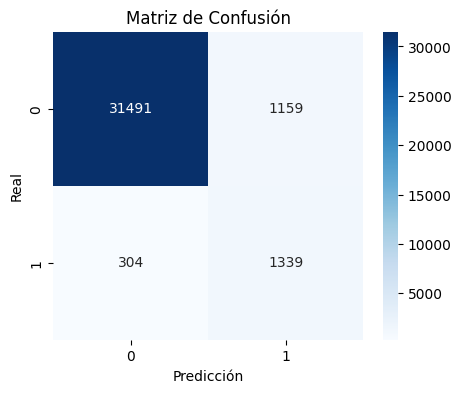

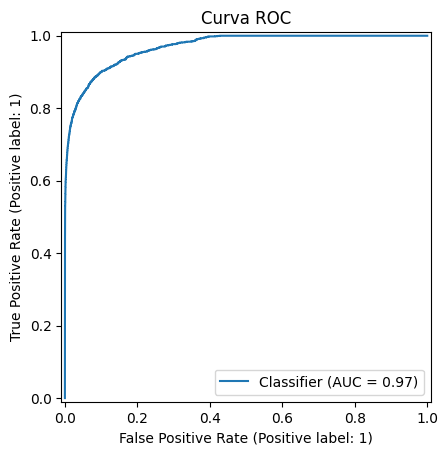

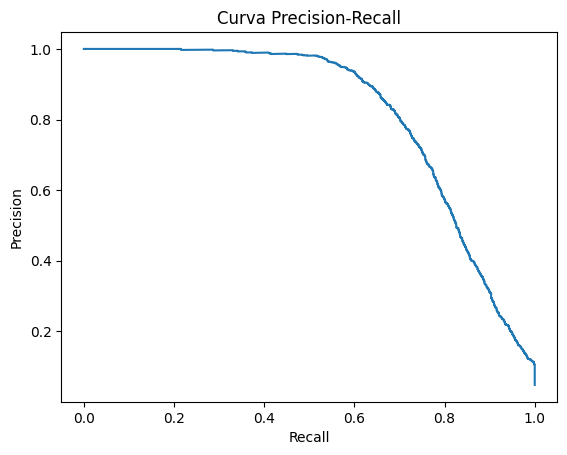

In [35]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]

# --- Métricas Numéricas ---
print("AUC-ROC:", roc_auc_score(y_test, probs))
print("AUC-PR (Precision-Recall):", average_precision_score(y_test, probs))
print("\nClassification Report:\n", classification_report(y_test, preds))

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# --- Curva ROC ---
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, probs)
plt.title("Curva ROC")
plt.show()

# --- Curva Precision-Recall ---
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.plot(recall, precision)
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()



# Conclusion Final del Proyecto

En general, el proyecto logra cumplir su objetivo principal: construir un modelo capaz de detectar transacciones financieras fraudulentas usando informacion generada por el simulador PaySim. Aunque los datos son sinteticos y tienen limitaciones, permitieron entrenar modelos de clasificacion que identifican patrones importantes entre operaciones reales y fraudulentas.

El modelo final muestra un desempeno bastante bueno, logrando diferenciar casi siempre entre transacciones normales y fraudes, incluso con un dataset muy desbalanceado. Las metricas obtenidas (AUC-ROC cercano a 0.97 y AUC-PR arriba de 0.81) indican que el modelo es estable y confiable, detectando la mayoria de los fraudes sin generar un exceso de alertas falsas. Esto demuestra que las variables seleccionadas aportan informacion util para reconocer comportamientos sospechosos, aun cuando algunas columnas no pueden usarse por temas de logica operativa.

En resumen, los resultados muestran que es posible crear un sistema de deteccion temprana de fraude que apoye a instituciones financieras a reducir perdidas y aumentar la seguridad. Si bien los datos sinteticos no capturan toda la complejidad del mundo real, este trabajo representa una buena base para posteriores mejoras con datos mas completos, metodos mas avanzados o ajustes segun las necesidades reales del negocio